In [2]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [166]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import ast

In [161]:
results = ap.DataDict.load(exp_name='BoidsModel', exp_id=3)

Loading from directory ap_output/BoidsModel_3/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [131]:
results.reporters

seed  \
sample_id iteration                                            
0         0           38151356693563145563839572916692094389   
          1          129896386350439104469743396241879195701   
          2          247300833332662290756255669384610199781   
1         0           50643080413437459039891721527947746584   
          1          136549452082586503894296593361224987154   
...                                                      ...   
254       1          141839946951262878138403903885345635124   
          2          248587756556688991619590204457588716429   
255       0          192115587585901810153584424217770613172   
          1          131620258500196733086493211183329561834   
          2           69770856444943625868461284060963808349   

                     initial_aligment  initial_cohesion  \
sample_id iteration                                       
0         0                  0.499722         19.475956   
          1                  0.499685         18.746250   
          2                  0.499441         18.998830   
1         0                  0.499948         19.168259   
          1                  0.499862         18.852328   
...                               ...               ...   
254       1                  0.499783         19.237000   
          2                  0.499764         19.264475   
255       0                  0.499890         19.543412   
          1                  0.498792         18.826670   
          2                  0.498784         19.309269   

                     initial_separation_min  initial_separation_max  \
sample_id iteration                                                   
0         0                        0.117845               66.152410   
          1                        0.083047               66.241880   
          2                        0.143870               66.269648   
1         0                        0.043852               67.875181   
          1                        0.046257               66.745948   
...                                     ...                     ...   
254       1                        0.062209               68.729670   
          2                        0.103458               67.013157   
255       0                        0.016598               68.178390   
          1                        0.034862               67.558101   
          2                        0.013511               67.781280   

                     initial_separation_avg  initial_border_distance_min  \
sample_id iteration                                                        
0         0                       26.561565                     0.017801   
          1                       25.773145                     0.022708   
          2                       26.031549                     0.041656   
1         0                       26.177865                     0.062641   
          1                       25.798795                     0.090805   
...                                     ...                          ...   
254       1                       26.252191                     0.002243   
          2                       26.215184                     0.038411   
255       0                       26.625558                     0.048460   
          1                       25.694051                     0.076585   
          2                       26.217769                     0.004628   

                     initial_border_distance_max  initial_border_distance_avg  \
sample_id iteration                                                             
0         0                            24.944128                    12.243813   
          1                            24.952172                    12.768944   
          2                            24.985391                    12.637813   
1         0                            24.983450                    12.518009   
          1                            24.992712        

In [200]:
def process_data(X, Y, normalize=True, state=False):
    # Split the data into training+validation set and test set
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Split the training+validation set into separate training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

    # Convert pandas dataframes to numpy arrays (if not already in numpy format)
    X_train_np, Y_train_np = X_train.values, Y_train.values
    X_val_np, Y_val_np = X_val.values, Y_val.values
    X_test_np, Y_test_np = X_test.values, Y_test.values

    if normalize:
        # Initialize scalers for X and Y
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        # Fit and transform the training data
        X_train, Y_train= scaler_X.fit_transform(X_train_np), scaler_Y.fit_transform(Y_train_np)

        # Transform the validation and test data
        X_val, Y_val = scaler_X.transform(X_val_np), scaler_Y.transform(Y_val_np)
        X_test, Y_test = scaler_X.transform(X_test_np), scaler_Y.transform(Y_test_np)

    
    # Convert the numpy arrays back to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_val = torch.tensor(Y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [198]:
output_parameters = ['final_alignment', 'cohesion_separation_ratio', 'flock_density']
knobs = ['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']

Y = results.reporters[knobs]
X =  results.reporters[output_parameters]

X_train, Y_train, X_val, Y_val, X_test, Y_test = process_data(X, Y, normalize=True)

/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

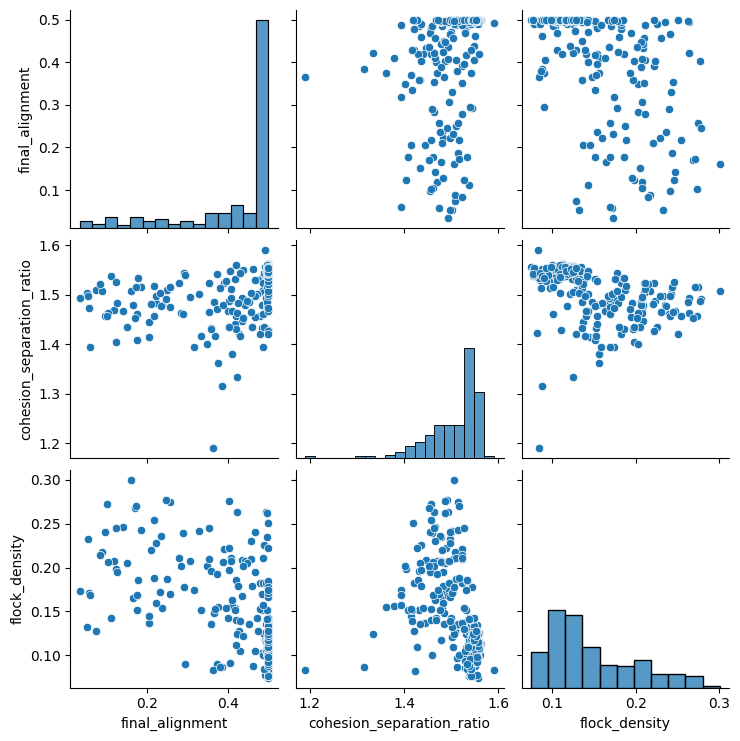

In [199]:
sns.pairplot(X)

In [192]:
correlation_matrix = X.corr()
print(correlation_matrix)

                           final_alignment  cohesion_separation_ratio  \
final_alignment                   1.000000                   0.397070   
cohesion_separation_ratio         0.397070                   1.000000   
flock_density                    -0.566109                  -0.412134   

                           flock_density  
final_alignment                -0.566109  
cohesion_separation_ratio      -0.412134  
flock_density                   1.000000  


In [193]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, X, Y):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [194]:
model = Net(X_train, Y_train)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(1000):  # Number of epochs
    optimizer.zero_grad()   # Zero the gradient buffers
    output = model(X_train)         # Pass the batch through the network
    loss = criterion(output, Y_train)  # Compute the loss
    loss.backward()         # Backpropagation
    optimizer.step()        # Update weights

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model with test data (if available)

Epoch 1, Loss: 1.0112346410751343
Epoch 101, Loss: 0.3776296377182007
Epoch 201, Loss: 0.291961133480072
Epoch 301, Loss: 0.22522620856761932
Epoch 401, Loss: 0.18730106949806213
Epoch 501, Loss: 0.17644275724887848
Epoch 601, Loss: 0.15993233025074005
Epoch 701, Loss: 0.1505836844444275
Epoch 801, Loss: 0.13613839447498322
Epoch 901, Loss: 0.12853199243545532


In [195]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Do not calculate gradients to save memory
    # Calculate the predictions for the test set
    Y_pred = model(X_test)

    # Calculate the loss for the test set
    test_loss = criterion(Y_pred, Y_test)

print(f'Test loss: {test_loss.item()}')

Test loss: 1.0745919942855835


In [196]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predictions for the test set
Y_pred = model(X_test)

# Convert the predictions and true values to NumPy arrays
Y_pred_np = Y_pred.detach().numpy()
Y_test_np = Y_test.numpy()

# Calculate the metrics
mae = mean_absolute_error(Y_test_np, Y_pred_np)
mse = mean_squared_error(Y_test_np, Y_pred_np)
r2 = r2_score(Y_test_np, Y_pred_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 0.7317098379135132, MSE: 1.0745919942855835, R^2: -0.09992430236836555


/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

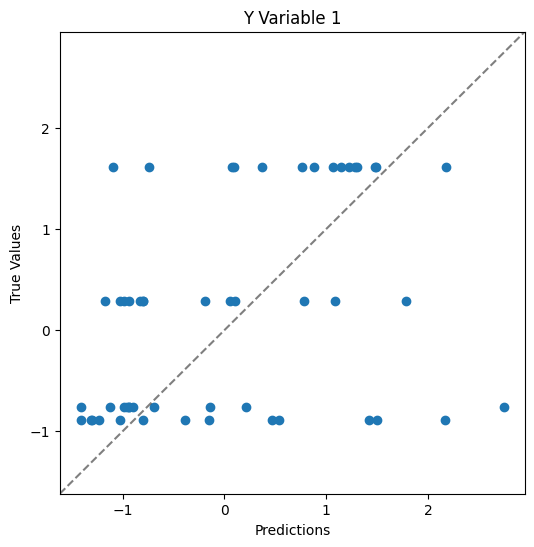

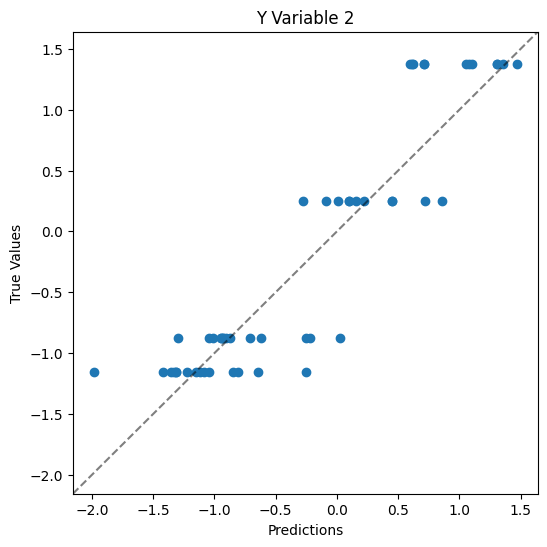

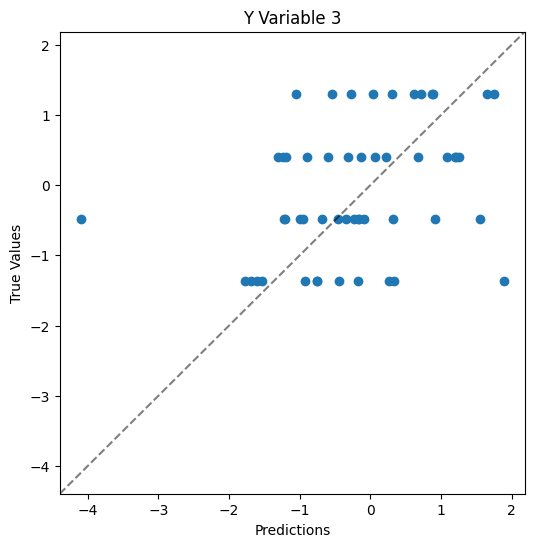

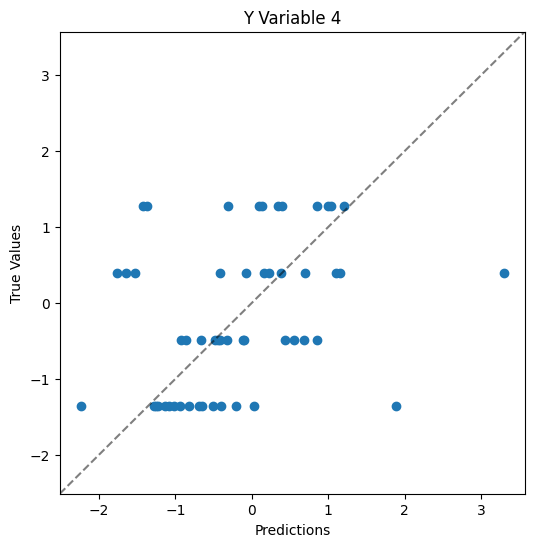

In [197]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred_np[:, i], Y_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()